# The problem with overfitting

In [124]:
import numpy as np
from pydataset import data
from numpy.linalg import inv
from numpy.random import randn, seed

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 7)

## A first example: A toy model of a 1D linear regression with polynomial parameters

In [36]:
seed(1643)
# Creating the underlying model.
training_points = 50
# Creating slighly sparsed independent variables
x = np.linspace(0, 1.5, training_points).reshape(1,-1) + randn(training_points) * 0.0001
# Real underlying parameters for x**6, x**5, ..., x**0
theta = np.array([1.5, 0.9, 0.5, 1.2, 0.1, 0.4, 1]).reshape(-1, 1)

# Observed dependent variables
f = np.poly1d(theta.ravel())
y = f(x) + randn(training_points) * 3

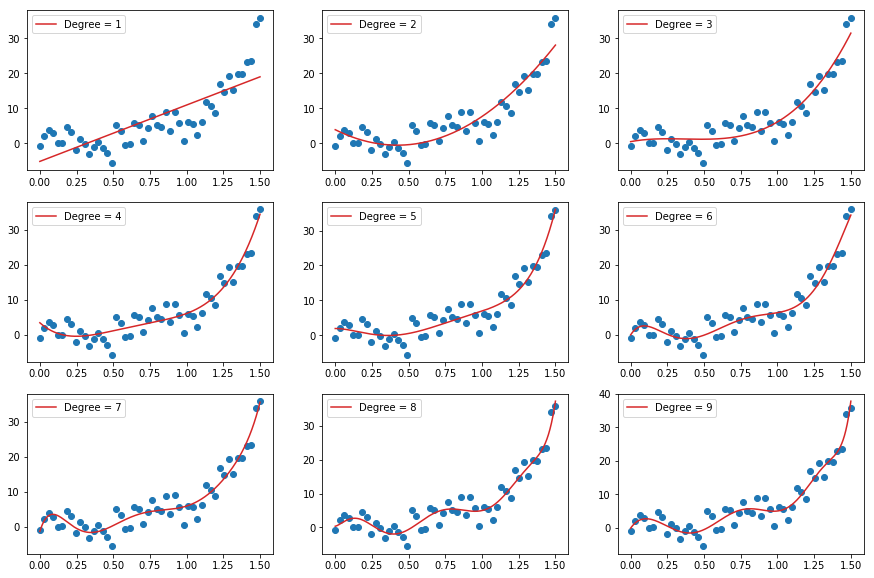

In [51]:
# Number of degrees to test
degrees = range(1, 10)
# Creating different training datasets assuming the model is a polynomial
# degree = 1, ..., degrees[-1]
Xdgs_train = [np.r_[tuple(x**i for i in range(d, -1, -1 ))] for d in degrees]
# Reshaping y to fit into model. Notice we have the same dependent observation,
# but assuming different underlying models
Y = y.reshape(-1, 1)
# Compute all optimal parameters for each x in Xdgs_train
thetas = [inv(X @ X.T) @ X @ Y for X in Xdgs_train]

# range to plot presumed underlying model
xrange = np.linspace(0, 1.5, 1000)
# Predicted yhat
yhats = [np.poly1d(theta.ravel())(xrange) for theta in thetas]

fig = plt.figure(figsize=(15,10))
for ix, (yhat, d) in enumerate(zip(yhats, map(len, thetas))):
    ax = fig.add_subplot(3, 3, ix + 1)
    ax.scatter(x, y)
    ax.plot(xrange, yhat, label=f"Degree = {d - 1}", color="tab:red")
    ax.legend(loc="upper left")
    

# Computing resulting model costs
costs_train = [np.linalg.norm(theta.T @ X - Y.T, 2) for X, theta in zip(Xdgs_train, thetas)]

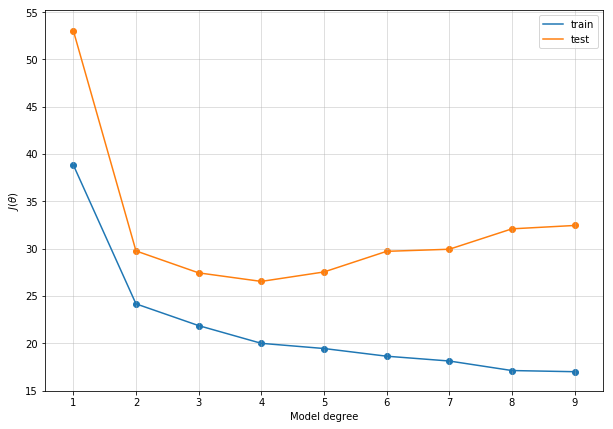

In [125]:
seed(31415)

# Sampling new test datapoints
test_points = 100
xtest = np.linspace(0, 1.5, test_points).reshape(1, -1)
ytest = (f(xtest) + randn(test_points) * 3).reshape(-1, 1)

Xdgs_test = [np.r_[tuple(xtest**i for i in range(d, -1, -1 ))] for d in degrees]
costs_test = [np.linalg.norm(theta.T @ X - ytest.T, 2) for X, theta in zip(Xdgs_test, thetas)]

plt.plot(degrees, costs_train, label="train")
plt.scatter(degrees, costs_train)

plt.plot(degrees, costs_test, label="test")
plt.scatter(degrees, costs_test)

plt.legend()
plt.ylabel(r"$J(\theta)$")
plt.xlabel(r"Model degree")
plt.grid(alpha=0.5)

## The regularization term $\lambda$ and the Ridge Regression

$$
    J(\theta) = ||\theta^T X - y^T||_2^2 + \lambda \ ||\theta||_2^2
$$

In [150]:
import requests
from zipfile import ZipFile
from io import BytesIO
import os
from sklearn.model_selection import train_test_split

students_url = ("http://archive.ics.uci.edu/ml/"
                "machine-learning-databases/"
                "00320/student.zip")

data = requests.get(students_url)
zipped = ZipFile(BytesIO(data.content))
if not os.path.exists("students/"):
    os.makedirs("students")
zipped.extractall("students")
del data

In [194]:
# Read the data
students = pd.read_table("students/student-mat.csv", sep=";")
# Compute the average grade for all three terms
students["avgG"] = students[["G1", "G2", "G3"]].mean(axis=1)
# Remove grades from first, second and third perido (we want to predict)
# the average
students.drop(["G1", "G2", "G3"], axis=1, inplace=True)
# Encode categorical variables as binary
students = pd.get_dummies(students)
students.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,3,4,3,2,2,...,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,1,0,1,1,0,1,0


Text(0.5,1,"Students' grade frequency")

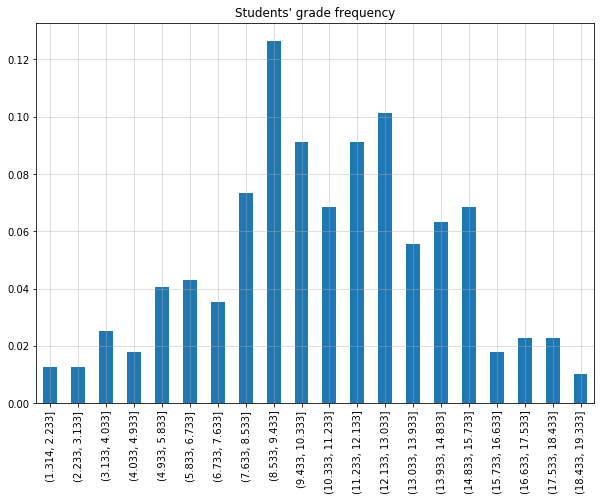

In [195]:
students["avgG"].value_counts(bins=20, sort=False, normalize=True).plot(kind="bar", color="tab:blue")
plt.grid(alpha=0.5)
plt.title("Students' grade frequency")

In [209]:
avgG_ix = list(students.columns).index("avgG")
rangcols = range(students.shape[1])

In [225]:
seed(1643)
train, test = train_test_split(students.values, test_size=0.15)

X_train, y_train = train[:, [ix for ix in rangcols if ix != avgG_ix]].T, train[:, avgG_ix].reshape(-1,1)
X_test, y_test = test[:, [ix for ix in rangcols if ix != avgG_ix]].T, test[:, avgG_ix].reshape(-1,1)

In [226]:
X_train.shape, X_test.shape

((56, 335), (56, 60))

In [273]:
lmbdas = range(0, 5)
thetas_opt = [inv(X_train @ X_train.T + lmba) @ X_train @ y_train for lmba in lmbdas]

# Cost on training
costs_train = [((theta.T @ X_train - y_train.T) @ (theta.T @ X_train - y_train.T).T / len(X_train.T))[0][0]
               for theta in thetas_opt]
# Cost on test
costs_test = [((theta.T @ X_test - y_test.T) @ (theta.T @ X_test - y_test.T).T / len(X_test.T))[0][0]
              for theta in thetas_opt]

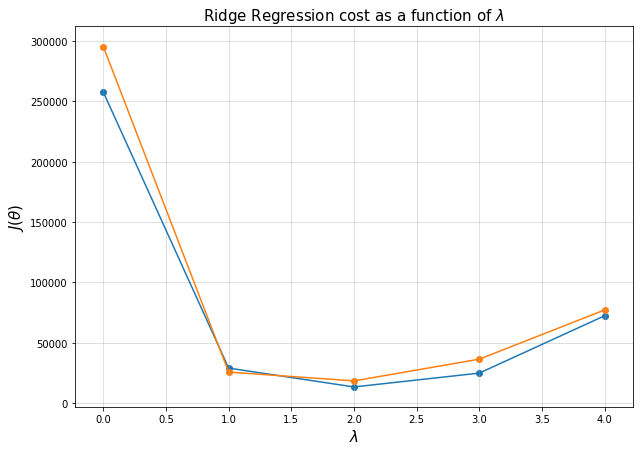

In [289]:
plt.plot(lmbdas, costs_train)
plt.scatter(lmbdas, costs_train)
plt.plot(lmbdas, costs_test)
plt.scatter(lmbdas, costs_test)
plt.title(r"Ridge Regression cost as a function of $\lambda$", fontsize=15)
plt.xlabel(r"$\lambda$", fontsize=15)
plt.ylabel(r"$J(\theta)$", fontsize=15)
plt.grid(alpha=0.5)

*******